In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from time import time
import random
import json
import argparse

from data_loader import SeqDataLoader
from pot import get_threshold
from models.CNN_LSTM import CNN_LSTM
from models.Res_CNN_LSTM import Res_CNN_LSTM
from models.Res_SE_CNN_LSTM import Res_SE_CNN_LSTM
from models.SE_CNN_LSTM import SE_CNN_LSTM
from models.LSTMPredictor import LSTMPredictor


In [2]:
def set_global_seed(seed=42):
    # 设置 Python 的随机种子
    random.seed(seed)
    # 设置 NumPy 的随机种子
    np.random.seed(seed)
    # 设置 PyTorch 的 CPU 随机种子
    torch.manual_seed(seed)
    # 设置 PyTorch 的 CUDA 随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # 禁用 CUDA 卷积操作的非确定性算法
        torch.backends.cudnn.deterministic = True
        # 禁用 CUDA 卷积操作的自动寻找最优算法
        torch.backends.cudnn.benchmark = False

set_global_seed()

In [3]:

# config_path = './run_swat.json'
# if not os.path.exists(config_path):
#     raise FileNotFoundError(f"Config file not found: {config_path}")
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
# with open(config_path, 'r') as f:
#     config = json.load(f)
# model_list = [Res_SE_CNN_LSTM 0, Res_CNN_LSTM 1, CNN_LSTM 2, SE_CNN_LSTM 3, LSTMPredictor 4]

config = {
    "dataset_args": {
        "dataset": "swat",
        "train_data_path": "./dataset/swat/train.csv",
        "test_data_path": "./dataset/swat/test.csv",
        "winsize": 30,
        "step": 10
    },
    "model_args": {
        "model": 0,
        "input_dim": 51,
        
        "cnn1": 64,
        "k1": 5,
        "pad1": 2,
        "SEratio1": 16,
        "maxpool1": 2,

        "cnn2": 32,
        "k2": 5,
        "pad2": 2,
        "maxpool2": 2,
        "SEratio2": 16,

        "hidden_dim": 32,
        "lstm_layers": 1
    },
    "training_args": {
        "model_dir": None,
        "lr": 0.01,
        "epochs": 10,
        "batch_size": 32,
        "AE_MODEL": False,
        "threshold": 0.5
    }
}

dataset_args = config["dataset_args"]
model_args = config["model_args"]
training_args = config["training_args"]

AE_MODEL = training_args["AE_MODEL"]   # 是否是自编码器模型

# 检测是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:

"""数据加载"""
dataset_name = dataset_args["dataset"]
train_data = SeqDataLoader(dataset_path=dataset_args["train_data_path"], win_size=dataset_args["winsize"], step=dataset_args["step"], name=f"{dataset_name} Train")
print(f'Train data length: {len(train_data)}')
print('Data sample shape:', train_data[0][0].shape)

"""数据加载"""
dataset_name = dataset_args["dataset"]
test_data = SeqDataLoader(dataset_path=dataset_args["test_data_path"], win_size=dataset_args["winsize"], step=1, name=f"{dataset_name} Test")
y_true = test_data.get_test_labels()
print(f'Test data length {len(test_data)}')
print(f'Test set Normal : {np.sum(y_true == 0)}; Attack : {np.sum(y_true == 1)}')
print('Data sample shape:', test_data[0][0].shape)
y_true_1 = np.where(y_true==1)[0]
print(len(y_true_1))

Loading swat Train data, window size is 30, step is 10
swat Train data shape: (495000, 51)
Train data length: 49497
Data sample shape: (30, 51)
Loading swat Test data, window size is 30, step is 1
swat Test data shape: (449919, 51)
Test data length 449889
Test set Normal : 395298; Attack : 54621
Data sample shape: (30, 51)
54621


Res_SE_CNN_LSTM


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, batch 0, loss: 0.8670611381530762
Epoch 0, batch 500, loss: 0.10241104662418365
Epoch 0, batch 1000, loss: 0.04245574772357941
Epoch 0, batch 1500, loss: 0.05664663389325142


 10%|█         | 1/10 [00:17<02:41, 17.99s/it]

Epoch 1, batch 0, loss: 0.0806591808795929
Epoch 1, batch 500, loss: 0.13655449450016022
Epoch 1, batch 1000, loss: 0.07318919152021408
Epoch 1, batch 1500, loss: 0.06570598483085632


 20%|██        | 2/10 [01:09<05:03, 37.95s/it]

Epoch 2, batch 0, loss: 0.03228558599948883
Epoch 2, batch 500, loss: 0.11100990325212479
Epoch 2, batch 1000, loss: 0.06528083235025406
Epoch 2, batch 1500, loss: 0.05743694677948952


 30%|███       | 3/10 [02:10<05:37, 48.28s/it]

Epoch 3, batch 0, loss: 0.1040252298116684
Epoch 3, batch 500, loss: 0.04617873206734657
Epoch 3, batch 1000, loss: 0.06040886789560318
Epoch 3, batch 1500, loss: 0.1266559362411499


 40%|████      | 4/10 [03:13<05:25, 54.27s/it]

Epoch 4, batch 0, loss: 0.08803839981555939
Epoch 4, batch 500, loss: 0.140352264046669
Epoch 4, batch 1000, loss: 0.04835563153028488
Epoch 4, batch 1500, loss: 0.05406047776341438


 50%|█████     | 5/10 [03:56<04:10, 50.16s/it]

Epoch 5, batch 0, loss: 0.033008791506290436
Epoch 5, batch 500, loss: 0.08438507467508316
Epoch 5, batch 1000, loss: 0.04853266850113869
Epoch 5, batch 1500, loss: 0.03665731102228165


 60%|██████    | 6/10 [04:46<03:20, 50.10s/it]

Epoch 6, batch 0, loss: 0.11943317949771881
Epoch 6, batch 500, loss: 0.0431414358317852
Epoch 6, batch 1000, loss: 0.022653233259916306
Epoch 6, batch 1500, loss: 0.017991911619901657


 70%|███████   | 7/10 [05:39<02:32, 50.92s/it]

Epoch 7, batch 0, loss: 0.16793088614940643
Epoch 7, batch 500, loss: 0.03284541890025139
Epoch 7, batch 1000, loss: 0.057454608380794525
Epoch 7, batch 1500, loss: 0.06052492558956146


 80%|████████  | 8/10 [06:33<01:43, 52.00s/it]

Epoch 8, batch 0, loss: 0.09956029057502747
Epoch 8, batch 500, loss: 0.14337225258350372
Epoch 8, batch 1000, loss: 0.06401766836643219
Epoch 8, batch 1500, loss: 0.023218689486384392


 90%|█████████ | 9/10 [07:29<00:53, 53.23s/it]

Epoch 9, batch 0, loss: 0.04074829816818237
Epoch 9, batch 500, loss: 0.1320725977420807
Epoch 9, batch 1000, loss: 0.07716243714094162
Epoch 9, batch 1500, loss: 0.031262319535017014


100%|██████████| 10/10 [08:24<00:00, 50.49s/it]


Model saved to ./checkpoints/Res_SE_CNN_LSTM_swat_1743303457.pth


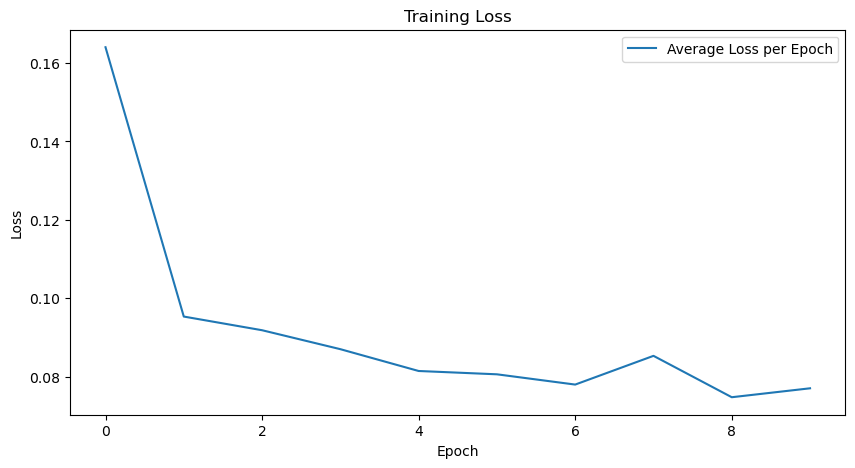

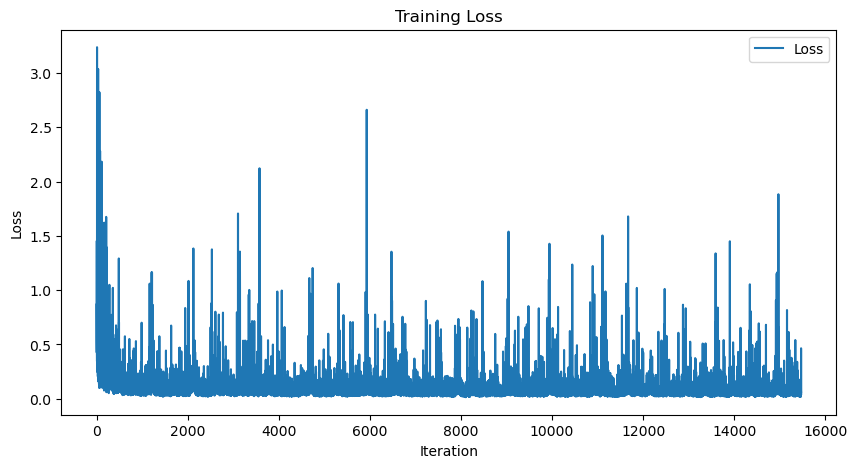

Config saved to ./checkpoints/Res_SE_CNN_LSTM_swat_1743303457.json


In [5]:

"""模型创建"""
data_dim = train_data[0][0].shape[-1]
model_list = [Res_SE_CNN_LSTM, Res_CNN_LSTM, CNN_LSTM, SE_CNN_LSTM, LSTMPredictor]
model = model_list[model_args["model"]](model_args)  # 选择模型
# model = SE_CNN_LSTM(model_args)  # 选择模型
print(model.ModelName)
model.to(device)  # 将模型移动到GPU上

filenameWithoutExt = f'{model.ModelName}_{dataset_args["dataset"]}_{int(time())}'

"""模型训练"""
learning_rate = training_args["lr"]
num_epochs = training_args["epochs"]
batch_size = training_args["batch_size"]
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 训练循环，显示进度条
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for i, (x, x_1) in enumerate(data_loader):
        optimizer.zero_grad()
        x = x.to(device)  # 将数据移动到GPU上
        x_1 = x_1.to(device)  # 将数据移动到GPU上
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])  # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)  # 下一步的数据作为预测目标
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 500 == 0:
            print(f'Epoch {epoch}, batch {i}, loss: {loss.item()}')
# 保存模型
torch.save(model.state_dict(), f"./checkpoints/{filenameWithoutExt}.pth")
config["training_args"]["model_dir"] = f"./checkpoints/{filenameWithoutExt}.pth"
print(f"Model saved to ./checkpoints/{filenameWithoutExt}.pth")
# 每个epoch的平均损失
avg_loss = [np.mean(losses[i:i+len(data_loader)]) for i in range(0, len(losses), len(data_loader))]
# 绘制训练损失曲线
plt.figure(figsize=(10, 5))
plt.plot(avg_loss, label='Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
# 绘图
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


"""结果保存"""
# 保存超参数结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config}, f, indent=4)
    print(f"Config saved to ./checkpoints/{filenameWithoutExt}.json")


100%|██████████| 1547/1547 [00:28<00:00, 53.74it/s]


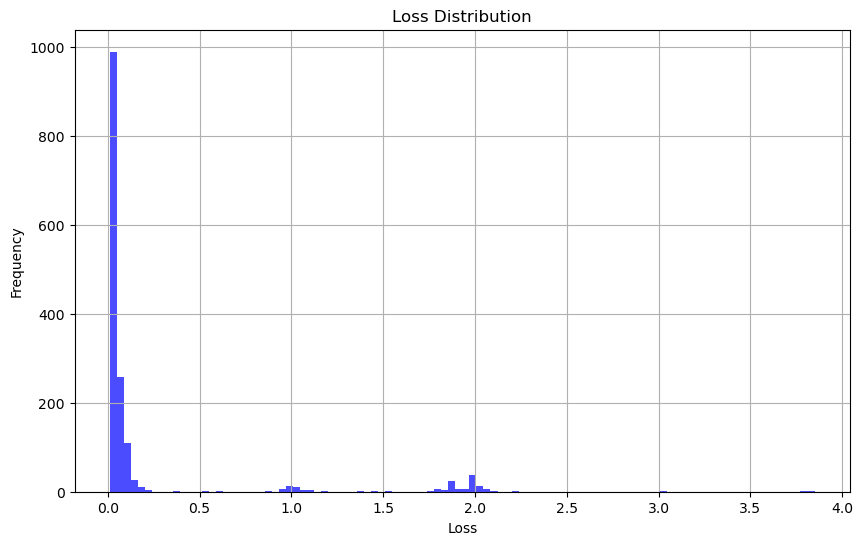

In [6]:
model.eval()
losses4train = []
with torch.no_grad():
    for x, x_1 in tqdm(data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)     # 下一步的数据作为预测目标

        losses4train.append(loss.item())

# 绘制误差数值分布，以便选择阈值
plt.figure(figsize=(10, 6))
plt.hist(losses4train, bins=100, color='blue', alpha=0.7)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.grid()
plt.savefig(f"./checkpoints/{filenameWithoutExt}_loss_distribution.png")
plt.show()


In [15]:
from scipy.stats import genpareto

# 使用POT方法拟合超阈值峰值
def fit_pot_with_threshold(errors, threshold):
    """
    使用POT方法拟合超阈值峰值，并返回GPD参数。
    :param errors: 误差序列
    :param threshold: 初始阈值
    :return: GPD参数 (scale, shape), 超阈值峰值
    """
    # 提取超阈值峰值（误差超过阈值的部分）
    exceedances = errors[errors > threshold] - threshold

    # 拟合广义帕累托分布 (GPD)
    params = genpareto.fit(exceedances, floc=0)  # 固定位置参数为0
    scale, shape = params[0], params[2]  # 提取尺度参数和形状参数

    return scale, shape, exceedances

# 设定初始阈值
threshold = 1

# 拟合GPD并获取参数
scale, shape, exceedances = fit_pot_with_threshold(np.array(losses4train), threshold)

print(f"Initial Threshold: {threshold}")
print(f"Fitted GPD Parameters - Scale: {scale}, Shape: {shape}")

# 计算最终阈值（根据置信水平设定）
confidence_level = 0.99  # 置信水平为99%
prob_exceed = 1 - confidence_level  # 超过该水平的概率
final_threshold = threshold + (scale / shape) * ((1 - prob_exceed) ** (-shape) - 1)
print(f"Final Threshold: {final_threshold}")

Initial Threshold: 1
Fitted GPD Parameters - Scale: -0.33845081787600395, Shape: 1.0948526321571523
Final Threshold: 0.9965796720987512


In [13]:
"""滚动预测
对模型输入窗口大小数据，预测下一步，若误差超过阈值，则标记为异常，且将数据中的下一步替换为预测值，继续预测下一步
"""
threshold = 1.0  # 选择阈值
criterion = nn.MSELoss()
test_data_list = test_data.get_test_data()
y_pred = np.zeros(len(test_data_list))
with torch.no_grad():
    for i in tqdm(range(len(test_data_list)-dataset_args["winsize"])):
        x = test_data_list[i:i+dataset_args["winsize"]]
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.unsqueeze(0)
        y_1 = test_data_list[i+dataset_args["winsize"]]
        y = model(x)
        y = y.squeeze(0).numpy()
        loss = criterion(torch.tensor(y), torch.tensor(y_1)).item()
        if loss > threshold:
            test_data_list[i+dataset_args["winsize"]] = y
            y_pred[i+dataset_args["winsize"]] = 1


100%|██████████| 449889/449889 [12:02<00:00, 623.01it/s]


In [15]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.95      0.41      0.58    395298
      Attack       0.17      0.85      0.28     54621

    accuracy                           0.47    449919
   macro avg       0.56      0.63      0.43    449919
weighted avg       0.86      0.47      0.54    449919



100%|██████████| 7030/7030 [05:46<00:00, 20.27it/s]


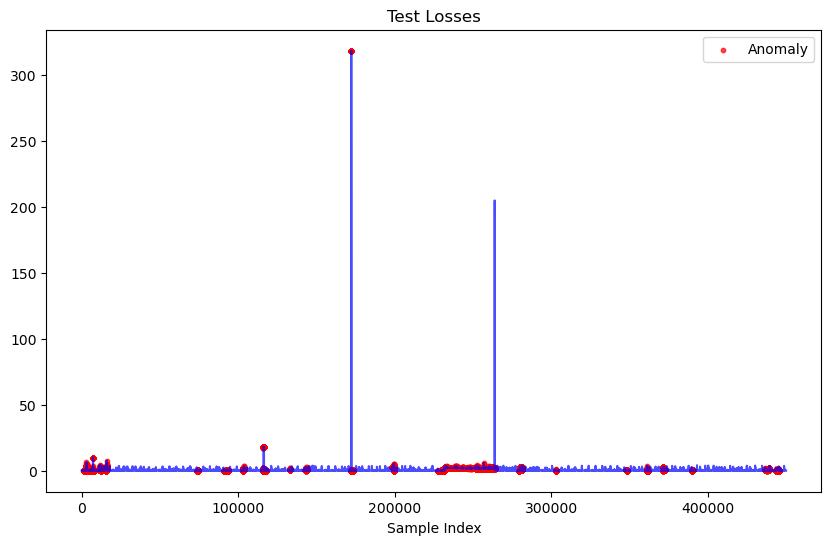

In [16]:

"""模型评估"""
test_losses = []
criterion = nn.MSELoss(reduction='none')
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # 评估所用batch_size不影响
with torch.no_grad():
    for x, x_1 in tqdm(test_data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:]).mean(dim=1)     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1).mean(dim=1)     # 下一步的数据作为预测目标

        test_losses += loss.tolist()

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(test_losses, color='blue', alpha=0.7)
plt.scatter(y_true_1, np.array(test_losses)[y_true_1], color='red', label='Anomaly', alpha=0.7, s=10)
plt.title('Test Losses')
plt.xlabel('Sample Index')
plt.legend()



In [17]:
config["training_args"]["threshold"] = 0.4
text = []
# thresholds = np.percentile(test_losses, [80, 85, 90, 95, 99]).tolist()
thresholds = np.arange(0.4, 1.51, 0.1).tolist()
# thresholds += [config["training_args"]["threshold"]]  

for threshold in thresholds:
    y_pred = (np.array(test_losses) > threshold).astype(int)
    if AE_MODEL:    
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]-1), y_pred]) # 自编码器的预测是窗口内的最后一步
        y_pred = np.concatenate([y_pred, np.zeros(1)])     # 由于数据集构造是面向预测的，最后一步不在训练集里面
    else:
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]), y_pred])  # 预测下一步
    text.append(f'threshold: {threshold}\n' + classification_report(y_true, y_pred, target_names=['Normal', 'Attack']) + '\n')
    print(text[-1])

"""结果保存"""
# 保存评估结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config, 'classification_report': text}, f, indent=4)

threshold: 0.4
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97    395298
      Attack       0.78      0.75      0.76     54621

    accuracy                           0.94    449919
   macro avg       0.87      0.86      0.86    449919
weighted avg       0.94      0.94      0.94    449919


threshold: 0.5
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97    395298
      Attack       0.82      0.72      0.77     54621

    accuracy                           0.95    449919
   macro avg       0.89      0.85      0.87    449919
weighted avg       0.95      0.95      0.95    449919


threshold: 0.6
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97    395298
      Attack       0.87      0.71      0.78     54621

    accuracy                           0.95    449919
   macro avg       0.91      0.85      0.88    449919
weighted avg       0.95    